# Load Packages

In [1]:
# Import sklearn
import sklearn
from sklearn.datasets import load_files 

# Import torch 
import torch
import torch.nn as nn
from torch import manual_seed as torch_manual_seed
from torch import Generator
from torch.optim import Adam
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
import torch.nn.functional as nnf

# Import other packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
import PIL
import PIL.Image
import random
from functools import partial
from timeit import default_timer as timer

# Random Seed for Reproduction

In [2]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Data

In [3]:
data_dir = "data/"

In [4]:
# Download and load the training data
dataset_all = ImageFolder(data_dir, transform=transforms.ToTensor())

# Print number in full data set
size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all) = {size_all}')

# Split into Test, Validation, and Training
size_test = int(size_all * 0.10)
size_val = int(size_all * 0.20)
size_train = size_all - size_test - size_val
dataset_test, dataset_val, dataset_train = random_split(dataset_all, [size_test, size_val, size_train], 
                                                        generator=Generator().manual_seed(SEED))

print(f'After splitting the full dataset into test, validation, and training: \n \
      len(dataset_test) = {len(dataset_test)} \n \
      len(dataset_val) = {len(dataset_val)} \n \
      len(dataset_train) = {len(dataset_train)}')

Before splitting the full dataset into train and test: len(dataset_all) = 600
After splitting the full dataset into test, validation, and training: 
       len(dataset_test) = 60 
       len(dataset_val) = 120 
       len(dataset_train) = 420


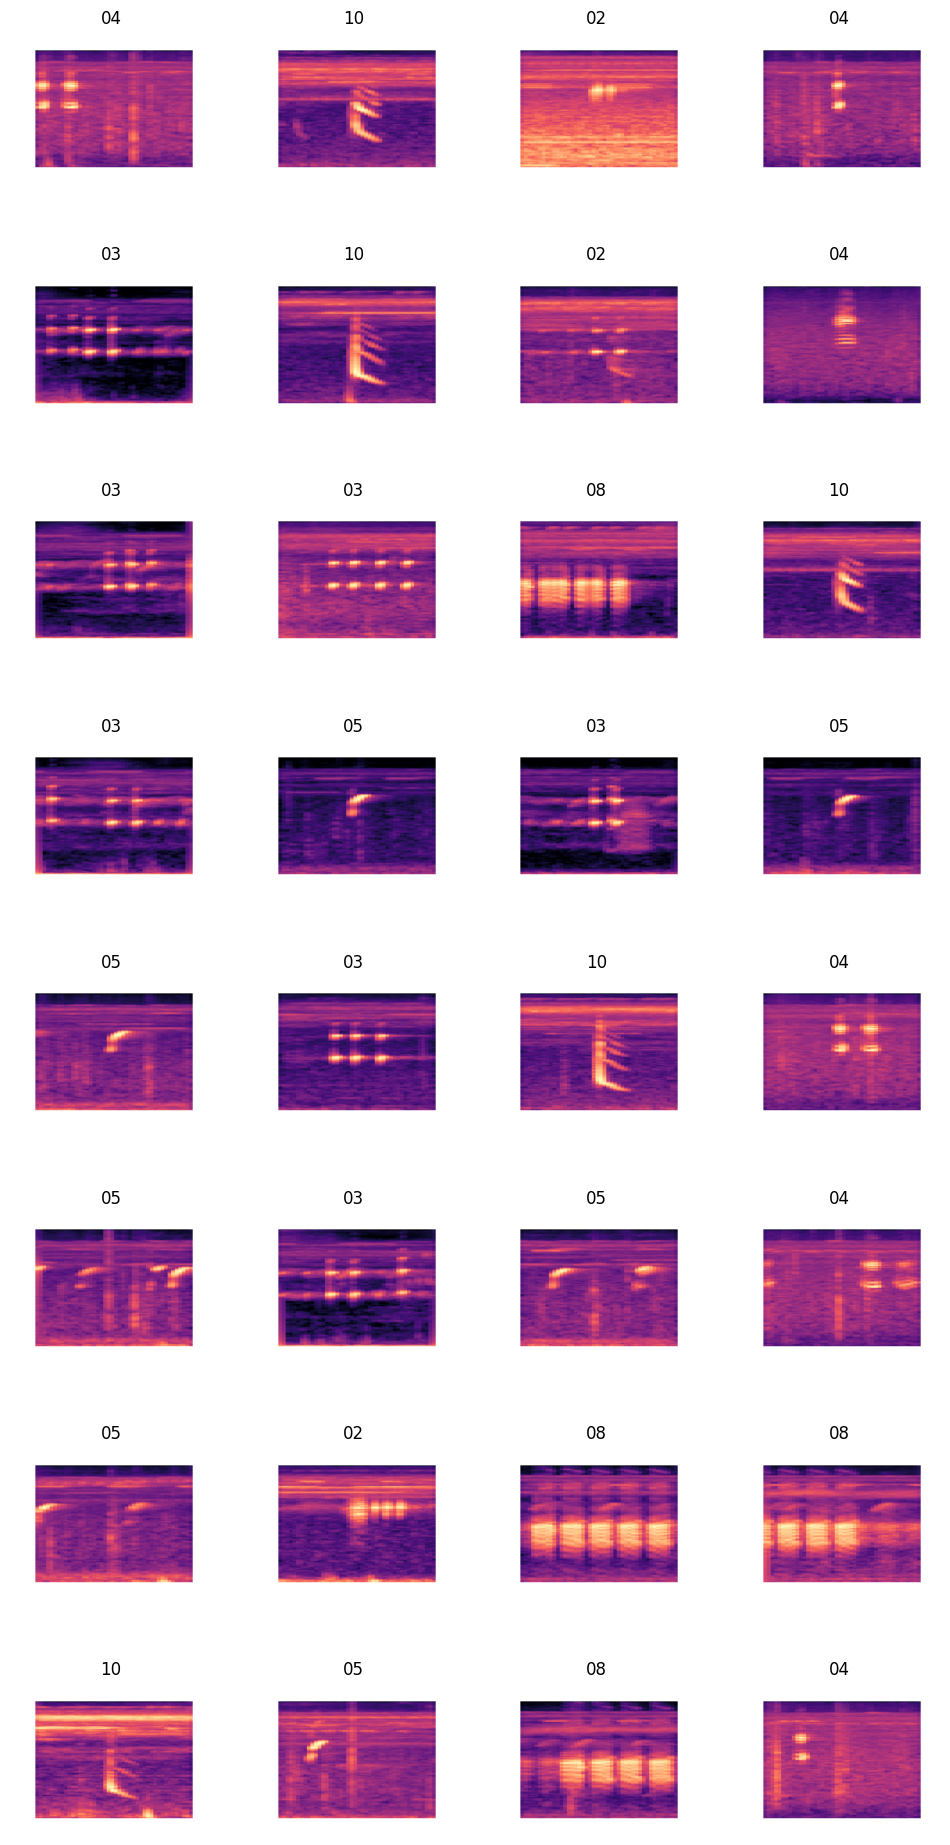

In [5]:
from torchvision.transforms.functional import to_pil_image

# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['02', '03', '04', '05', '08', '10']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

# Preparation

### Load Data into DataLoader

In [6]:
batch_size = 32

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_val)}

### Define Device Type and Number of Classes

In [7]:
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training Loop

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print current loss 
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        # Correct predictions
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    accuracy = correct / size

    # Print training error
    print(f"Training Error: Accuracy: {(100*accuracy):>0.1f}%")
    
    # Return training accuracy
    return accuracy

### Testing/Validation Loop

In [9]:
def test_loop(dataloader, model, loss_fn, method):
    probs = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            # Compute prediction
            pred = model(X)
            
            # Testing loss
            test_loss += loss_fn(pred, y).item()
            
            # Correct predictions 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Get probability values 
            prob = nnf.softmax(pred, dim=1)
            probs.append(pd.DataFrame(prob.cpu()))

    # Test loss
    test_loss /= num_batches
    
    # Test accuracy
    accuracy = correct / size
    
    # Get final probabilities
    probs = pd.concat(probs).reset_index(drop=True)
    probs = probs.rename(columns={0: 'Upper Amazon tree frog', 
                                  1: 'Demerara Falls tree frog',
                                  2: 'Chirping Robber frog',
                                  3: "Vanzolini's Amazon frog",
                                  4: "South American common toad",
                                  5: "Peters' dwarf frog"})
    
    if method=='val':
        print(f"Validation Error: Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        # Return accuracy
        return accuracy
    elif method=='test':
        print(f"Test Error: Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    elif method=='prob':
        return probs

# CNN Model (based on AlexNet architecture)

In [10]:
class Model(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()                 
        
        ### Convolutional Layers ###
        self.convolutional = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2), 
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        
            # Layer 2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),    
            nn.BatchNorm2d(256), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        
            # Layer 3
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),      
            nn.BatchNorm2d(384), 
            nn.ReLU(inplace=True),
        
            # Layer 4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),    
            nn.BatchNorm2d(384), 
            nn.ReLU(inplace=True),
        
            # Layer 5
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        ### Linear layers ###
        self.classifier = nn.Sequential(
        
            # Feature map to 6x6x256 size
            nn.AdaptiveAvgPool2d((6, 6)),
            # Flatten for fully connected layers
            nn.Flatten(),
            
            # Layer 1
            nn.Dropout(p=0.1),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
        
            # Layer 2
            nn.Dropout(p=0.1),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
        
            # Layer 3
            nn.Dropout(p=0.1),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        
            # Layer 4
            nn.Linear(in_features=4096, out_features=num_classes))
        
    # Forward 
    def forward(self, x):
        x = self.convolutional(x)
        x = self.classifier(x)
        return x

In [11]:
# Create model 
model = Model(num_classes=num_classes).to(device)
 
# Hyperparameters
learning_rate = 0.005
weight_decay = 0.005
momentum=0.09

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

### Train Model with Training Data

In [12]:
# Number of epochs
epochs = 15

# Get accuracy for each epoch
train_accuracies = [] 
val_accuracies = []  

# Loop
start = timer() 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Training
    model.train()
    train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_accuracy = test_loop(val_dataloader, model, loss_fn, method='val')
    val_accuracies.append(val_accuracy)
end = timer()
print(f'Processing time: {end-start:.2f}s.') 

Epoch 1
-------------------------------
loss: 1.786671  [   32/  420]
Training Error: Accuracy: 30.5%
Validation Error: Accuracy: 20.8%, Avg loss: 1.791216 

Epoch 2
-------------------------------
loss: 1.749958  [   32/  420]
Training Error: Accuracy: 45.7%
Validation Error: Accuracy: 20.8%, Avg loss: 1.779775 

Epoch 3
-------------------------------
loss: 1.650914  [   32/  420]
Training Error: Accuracy: 58.3%
Validation Error: Accuracy: 64.2%, Avg loss: 1.690739 

Epoch 4
-------------------------------
loss: 1.546595  [   32/  420]
Training Error: Accuracy: 70.5%
Validation Error: Accuracy: 70.0%, Avg loss: 1.454469 

Epoch 5
-------------------------------
loss: 1.547471  [   32/  420]
Training Error: Accuracy: 73.1%
Validation Error: Accuracy: 67.5%, Avg loss: 1.226212 

Epoch 6
-------------------------------
loss: 1.146906  [   32/  420]
Training Error: Accuracy: 80.2%
Validation Error: Accuracy: 79.2%, Avg loss: 0.956243 

Epoch 7
-------------------------------
loss: 0.8950

### Plot Training and Validation Accuracy

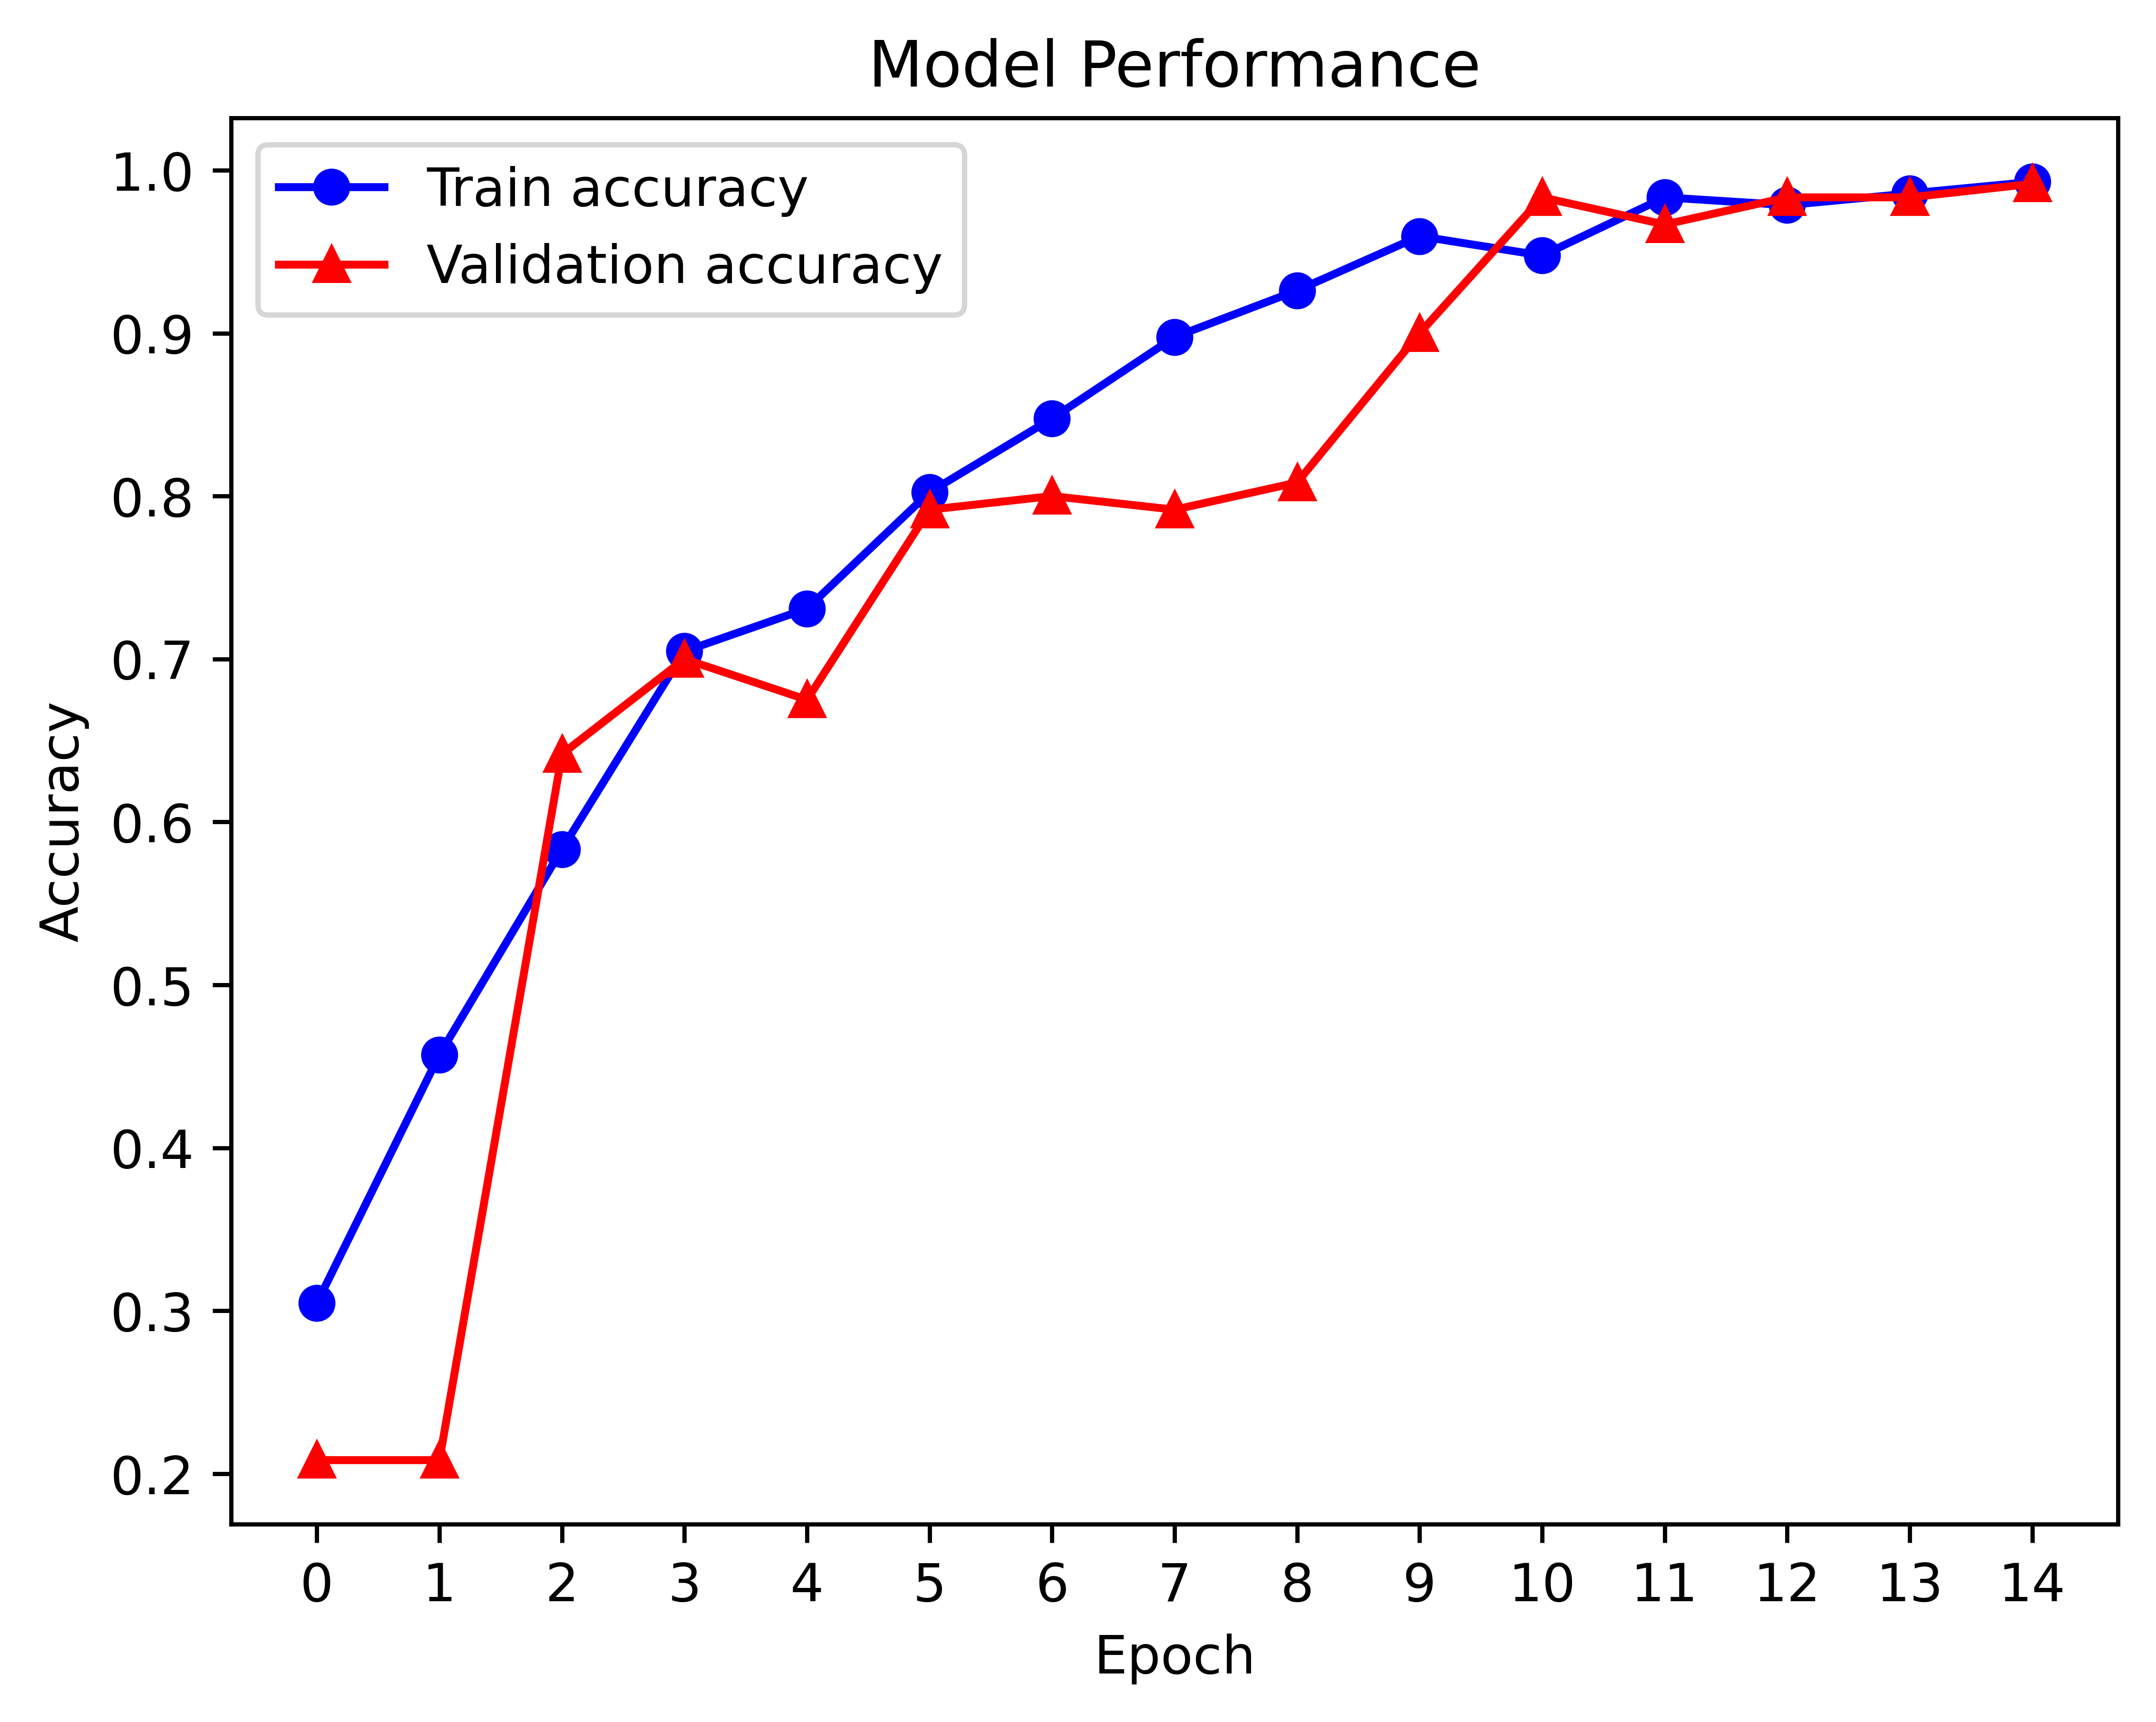

In [20]:
plt.plot(train_accuracies, 'bo-', label="Train accuracy")
plt.plot(val_accuracies, 'r^-', label="Validation accuracy")
plt.xticks(range(0,epochs))
plt.title("Model Performance", fontsize=12)
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test model

In [21]:
test_loop(test_dataloader, model, loss_fn, 'test')

Test Error: Accuracy: 100.0%, Avg loss: 0.081307 



### Get class prediction probabilities for each test image

In [22]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [23]:
predictions = test_loop(test_dataloader, model, loss_fn, 'prob')

In [24]:
predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog
0,0.001421,0.000045,0.000149,0.000017,0.002051,0.996317
1,0.000246,0.002548,0.000318,0.000011,0.992115,0.004762
2,0.828854,0.014569,0.006723,0.020055,0.003258,0.126541
3,0.328495,0.000583,0.000986,0.628742,0.000487,0.040706
4,0.037600,0.001340,0.001119,0.958862,0.000085,0.000992


### Plot probabilities

In [25]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

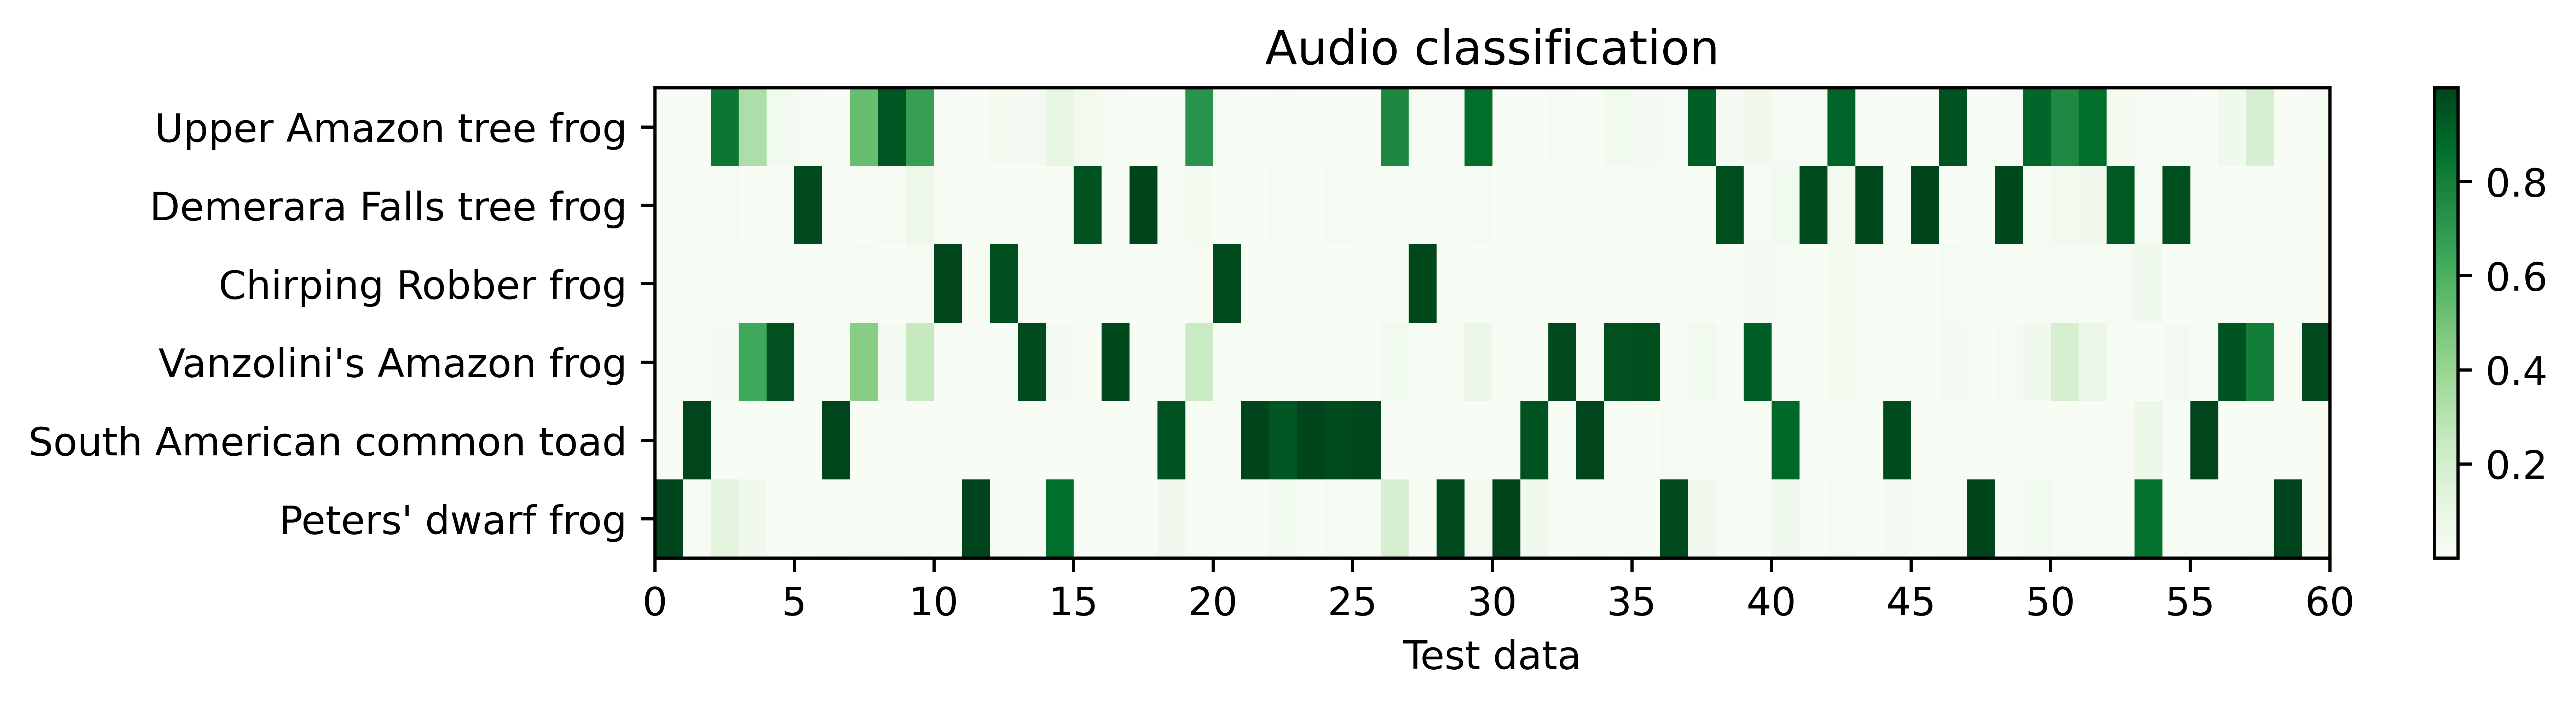

In [26]:
mpl.rcParams['figure.dpi'] = 800
  
fig, ax = plt.subplots(figsize=(10, 2))
plt.imshow(predictions.T, cmap='Greens', interpolation = 'nearest', origin='upper')
  
plt.title( "Audio classification" )

from matplotlib import ticker
positions = [0, 1, 2, 3, 4, 5]
labels = ['Upper Amazon tree frog',
          'Demerara Falls tree frog',
          'Chirping Robber frog',
          "Vanzolini's Amazon frog",
          'South American common toad',
          "Peters' dwarf frog"]

#highlight_cell(0, 5, color="red", linewidth=1.5)
#highlight_cell(1, 1, color="red", linewidth=1.5)
#highlight_cell(2, 4, color="red", linewidth=1.5)

ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.xticks(np.arange(-0.5, 60.5, 5), np.arange(0, 61, 5))
plt.xlabel('Test data')
plt.tight_layout()
ax.set_aspect('auto')
plt.colorbar()
plt.savefig('fig.png', bbox_inches='tight')

# Test on unidentified long audio file

In [41]:
test1_dir = "1s_test_chunks/"

In [42]:
# Download and load the training data
test1 = ImageFolder(test1_dir, transform=transforms.ToTensor())

In [43]:
test1_dataloader = DataLoader(test1, batch_size=batch_size, shuffle=True)

In [44]:
predictions = test_loop(test1_dataloader, model, loss_fn, 'prob')

In [45]:
predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog
0,0.859255,0.004758,0.031971,0.021581,0.006286,0.076150
1,0.831564,0.002351,0.004570,0.018931,0.007218,0.135366
2,0.820596,0.002038,0.004195,0.017421,0.005703,0.150047
3,0.800202,0.001514,0.004016,0.012490,0.004412,0.177365
4,0.838108,0.001699,0.004278,0.016124,0.004020,0.135771


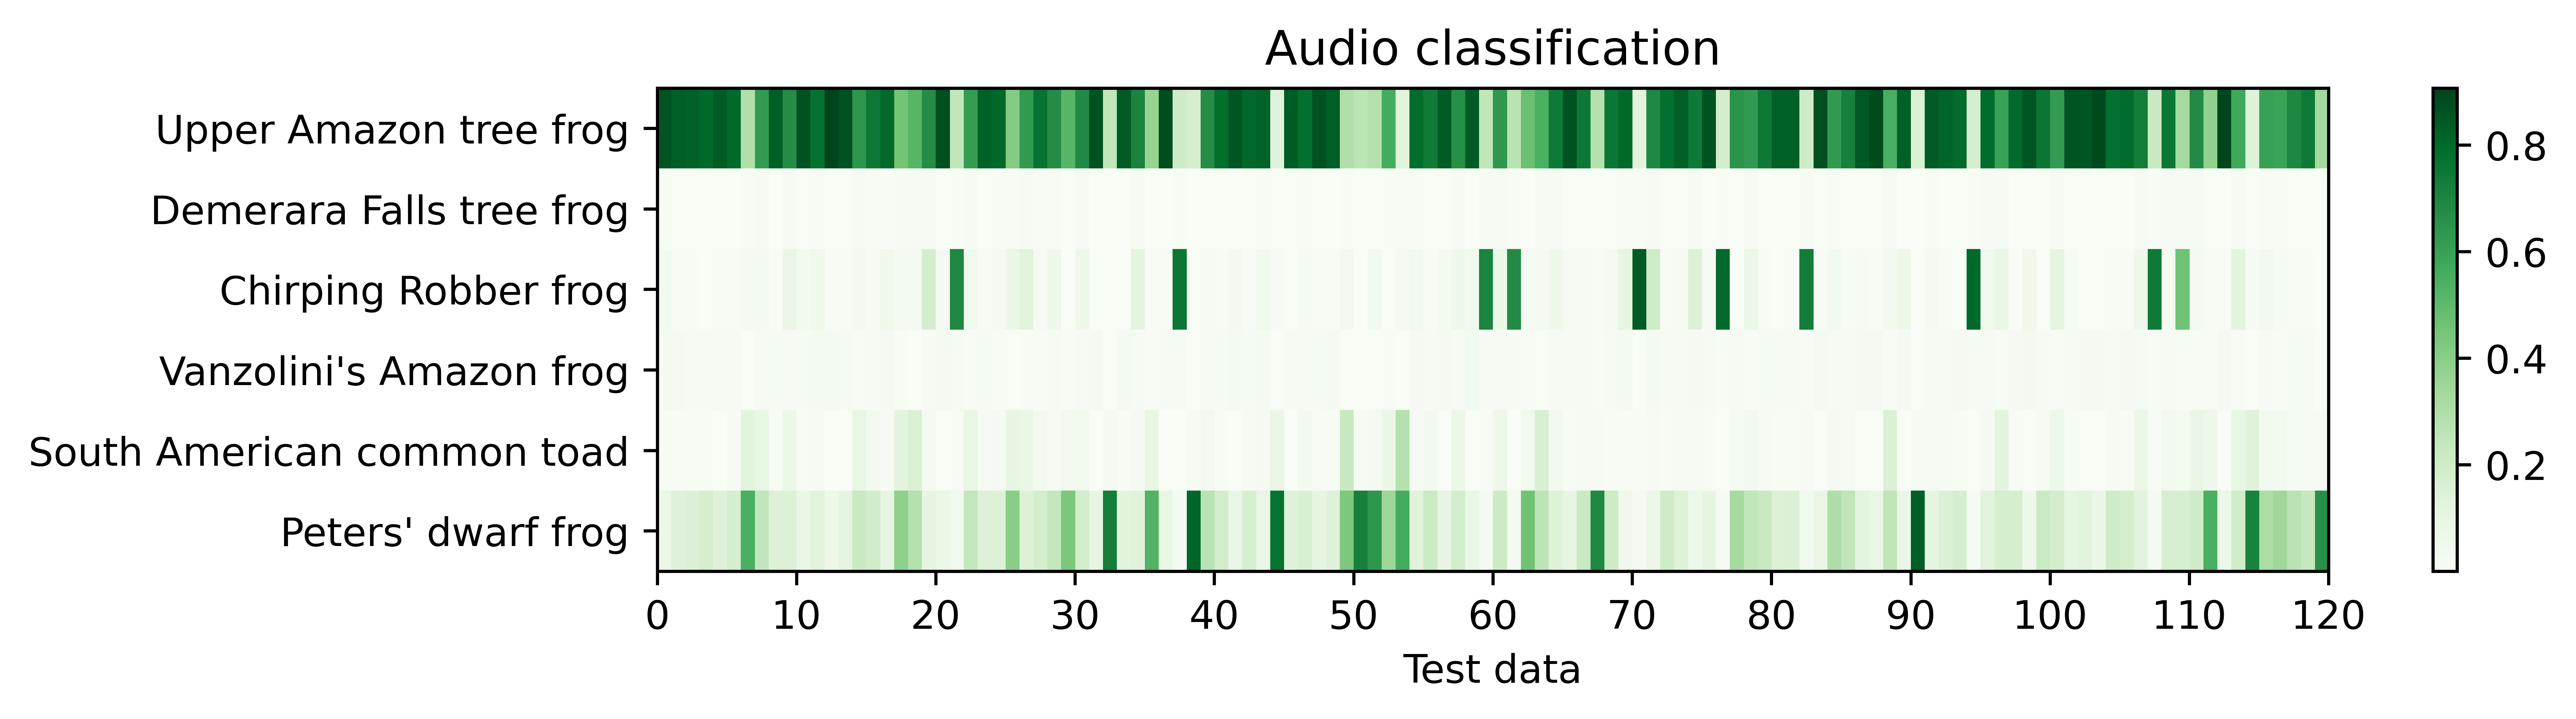

In [46]:
mpl.rcParams['figure.dpi'] = 800
  
fig, ax = plt.subplots(figsize=(10, 2))
plt.imshow(predictions.T, cmap='Greens', interpolation = 'nearest', origin='upper')
  
plt.title( "Audio classification" )

from matplotlib import ticker
positions = [0, 1, 2, 3, 4, 5]
labels = ['Upper Amazon tree frog',
          'Demerara Falls tree frog',
          'Chirping Robber frog',
          "Vanzolini's Amazon frog",
          'South American common toad',
          "Peters' dwarf frog"]

#highlight_cell(0, 5, color="red", linewidth=1.5)
#highlight_cell(1, 1, color="red", linewidth=1.5)
#highlight_cell(2, 4, color="red", linewidth=1.5)

ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.xticks(np.arange(-0.5, 120.5, 10), np.arange(0, 121, 10))
plt.xlabel('Test data')
plt.tight_layout()
ax.set_aspect('auto')
plt.colorbar()
plt.savefig('fig.png', bbox_inches='tight')